### head

In [1]:
from test_flow import ABCore as tf
import visualization as viz
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [2]:
path = r"C:\Users\repin\Desktop\GitHub\TestLab\development\test-data.csv"
df = pd.read_csv(path)

In [3]:
# добавим данные по месяцу и дате в удобном формате
df['month'] = df['Date'].apply(lambda x: x[:7])
df['dt'] = df['Date'].apply(lambda x: x[:10])

In [4]:
test_params = {
    "target_metric": "rto",
    "id_field": "CityName",
    "time_series_field": "dt",
    "number_of_neighbors": 3,
    "test_units": ['Пенза', 'Уфа', 'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск'],
    "alpha": 0.05,
    "cuped_time": 14,
    "start_of_test": "2022-04-07",
    "days_for_knn": 70,
    "days_for_validation": 14,
    "days_for_test": 14,
    "n_iter_bootstrap": 100_000,
}

In [5]:
exp = tf(params_dict=test_params)

In [6]:
exp.create_periods()

Подбор групп: с 2022-01-13 по 2022-03-24
Валидация: с 2022-03-24 по 2022-04-07
Тест: с 2022-04-07 по 2022-04-21


In [7]:
# данные для обучения knn
knn_data = df[
    (df['dt'] >= exp.start_of_knn) & (df['dt'] < exp.start_of_validation)
    & (df['OrderSource'] == 'web') & (df['Category'] == 'пицца')
    ]
knn_data.shape

(18420, 14)

In [8]:
knn_data = knn_data[["dt", "CityName", "rto"]]
knn_data = knn_data[~knn_data["CityName"].isin(["Москва", "Санкт-Петербург"])]

In [9]:
knn_data.head()

,dt,CityName,rto
36170,2022-01-13,Абакан,30913.82
36182,2022-01-13,Абинск,3409.35
36193,2022-01-13,Азов,10963.47
36204,2022-01-13,Аксай Россия,11807.18
36214,2022-01-13,Александров,8372.84


In [10]:
knn_data_pivot = knn_data.pivot_table(
    values=exp.target_metric,
    columns=exp.time_series_field,
    index=exp.id_field)

In [11]:
cols = list(knn_data_pivot.columns)

wrong_cities = []
for i in cols:
    one_row = knn_data_pivot.loc[:, i]
    if one_row.isnull().values.any():
        all_cities = list(one_row[one_row.isnull().values].index)
        for i in all_cities:
            if i not in wrong_cities:
                wrong_cities.append(i)

In [12]:
# оставляем города, включая мск и спб, кроме тех, где есть пропуски в данных
test_wo_denied_ = [i for i in set(knn_data[exp.id_field]) if i not in wrong_cities]

In [13]:
len(test_wo_denied_)

225

In [14]:
knn_data_clean = knn_data[knn_data[exp.id_field].isin(test_wo_denied_)]

In [15]:
knn_data.head()

,dt,CityName,rto
36170,2022-01-13,Абакан,30913.82
36182,2022-01-13,Абинск,3409.35
36193,2022-01-13,Азов,10963.47
36204,2022-01-13,Аксай Россия,11807.18
36214,2022-01-13,Александров,8372.84


In [16]:
knn_pre_exp_clean_scld = exp.get_scaled_data(knn_data_clean)

In [17]:
knn_pre_exp_clean_scld.head()

,dt,CityName,rto,scaled_rto
36170,2022-01-13,Абакан,30913.82,-0.117158
36182,2022-01-13,Абинск,3409.35,-0.661196
36193,2022-01-13,Азов,10963.47,-0.511776
36204,2022-01-13,Аксай Россия,11807.18,-0.495087
36214,2022-01-13,Александров,8372.84,-0.563019


In [18]:
knn_vectors, ids_dict = exp.get_vectors(knn_pre_exp_clean_scld)

In [19]:
exp.get_k_neighbors_default(knn_vectors, "Орск")

{145: 0.0, 163: 0.8292199291710258, 181: 0.8370046681002036}

In [20]:
exp.get_k_neighbors_dtw(knn_vectors, "Орск")

{'Анапа': 0.6141279166639553,
 'Прокопьевск': 0.6152168199560157,
 'Стерлитамак': 0.6189428055104526}

In [21]:
all_neighbours_dtw = exp.get_all_neighbors_dtw(knn_vectors)
all_neighbours_dtw

{'Пенза': ['Рязань', 'Чита', 'Благовещенск'],
 'Уфа': ['Оренбург', 'Волгоград', 'Томск'],
 'Курск': ['Волжский', 'Березники', 'Братск'],
 'Нижний Тагил': ['Мурино', 'Парголово', 'Братск'],
 'Новокуйбышевск': ['Альметьевск', 'Красное Село', 'Звенигород'],
 'Орск': ['Анапа', 'Прокопьевск', 'Стерлитамак']}

In [22]:
all_groups_dtw = exp.get_test_control_groups(all_neighbours_dtw)
all_groups_dtw

{'test_units': ['Пенза',
  'Уфа',
  'Курск',
  'Нижний Тагил',
  'Новокуйбышевск',
  'Орск'],
 'control_units': ['Рязань',
  'Оренбург',
  'Волжский',
  'Мурино',
  'Альметьевск',
  'Анапа']}

### VAL

In [23]:
# данные для валидации
from functools import reduce
import operator
all_units = reduce(operator.iconcat, all_groups_dtw.values(), [])
validation_data = df[
    (df['dt'] >= exp.start_of_validation) & (df['dt'] < exp.start_of_test)
    & (df['OrderSource'] == 'web') & (df['Category'] == 'пицца')
    & (df["CityName"].isin(all_units))
    ]
validation_data.shape

(168, 14)

In [24]:
from datetime import datetime
datetime.today().strftime("%Y%m%d_%H%M%S")

'20240718_131651'

In [25]:
exp.bootstrap(
    validation_data,
    np.mean,
    7000,
    directory_path="C:/Users/repin/Desktop/GitHub/TestLab/development/graphs",
    test_id="test"
)

  0%|          | 0/100000 [00:00<?, ?it/s]

{'aa_test': False,
 'ab_test': False,
 'pe_aa': 3018.8733166666716,
 'pe_ab': 10018.873316666672,
 'ci_aa': (-6939.742879374993, 13145.502081666662),
 'ci_ab': (-24.312326041666893, 20107.97943375),
 'p_value_aa_boot': 0.55579,
 'p_value_ab_boot': 0.05108}

In [25]:
all_groups_dtw

{'test_units': ['Пенза',
  'Уфа',
  'Курск',
  'Нижний Тагил',
  'Новокуйбышевск',
  'Орск'],
 'control_units': ['Рязань',
  'Оренбург',
  'Волжский',
  'Мурино',
  'Альметьевск',
  'Анапа']}

In [25]:
pilot_df_sort, pre_pilot_df_sort = exp.sort_merge_for_cuped(
    knn_data_clean,
    validation_data,
    all_groups_dtw
)

In [26]:
pilot_df_sort.shape

(168, 6)

In [27]:
pilot_df_sort.head(2)

,dt,CityName,rto,weekday,row_number,period
261026,2022-03-28,Альметьевск,14697.69,1,0,pilot
282240,2022-04-04,Альметьевск,8212.19,1,1,pilot


In [28]:
cuped_df = exp.calculate_cuped_metric(
    pre_pilot_df_sort,
    pilot_df_sort
)

Theta is: 1.1297825720556836


In [29]:
cuped_df.shape

(168, 11)

In [30]:
cuped_df.head(2)

,dt_prepilot,CityName,rto_prepilot,weekday_prepilot,row_number,period_prepilot,dt_pilot,rto_pilot,weekday_pilot,period_pilot,rto_cuped
0,2022-03-14,Альметьевск,12891.4247,1,0,history,2022-03-28,14697.69,1,pilot,133.183045
1,2022-03-21,Альметьевск,14125.3000,1,1,history,2022-04-04,8212.19,1,pilot,-7746.327765


### BOOTSTRAP in VAL with CUPED

  0%|          | 0/100000 [00:00<?, ?it/s]

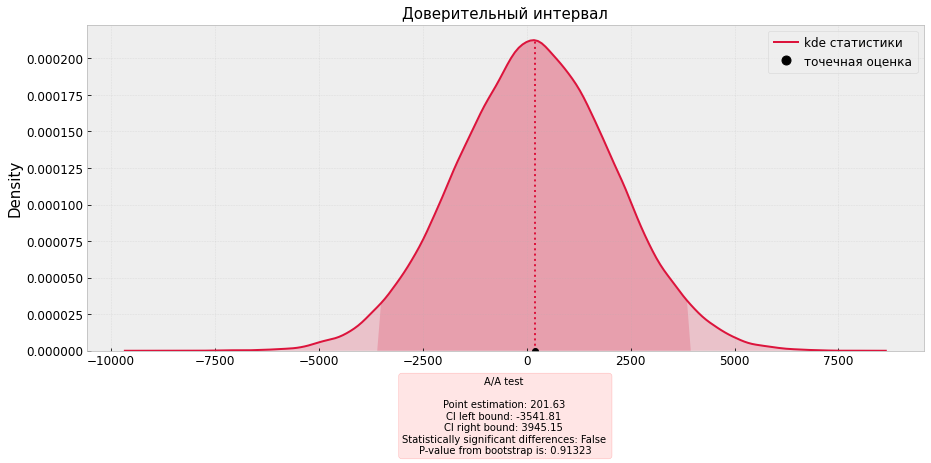

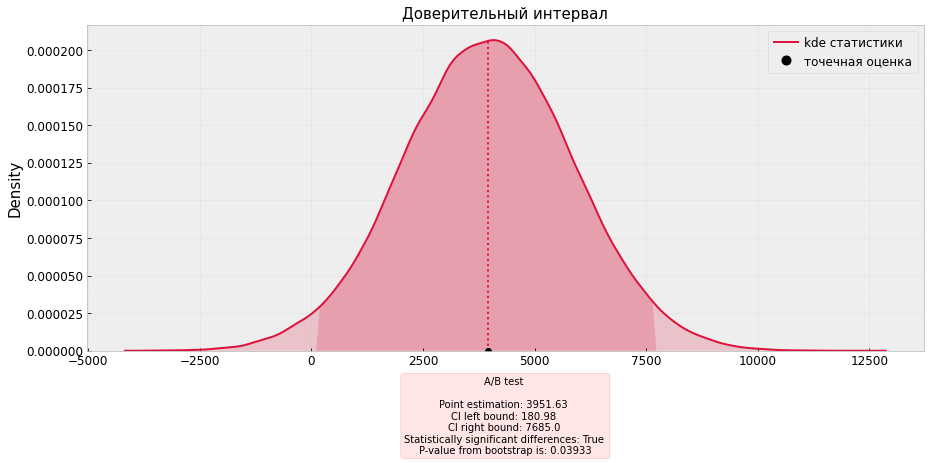

In [31]:
exp.bootstrap(
    cuped_df,
    np.mean,
    3750,
    is_cuped=True,
    verbose=True
)